## Perform linear regression on experimental data to continuously approximate how cell compositions change with growth rate. 

### Gather experimental values of ribosomes, ternary complexes, cell mass, and cell volume as a function of growth rate from literature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


#Active Ribosomes
x_rib = np.array([0.6,1.0,1.5,2.0,2.5,3.0])
y_rib = np.array([8000,15000,26000,44000,61000,73000])
y_rib = np.array([int(y_i*0.85) for y_i in y_rib])

#Ternary complexes
x_tern = np.array([0.4,0.7,1.07,1.6,2.5,3.0]+[0.4]*5)
y_tern = np.array([48000,57000,83000,143000,323000,383000]+[48000]*5)

#Cell mass
x_mass = np.array([0.6,1.0,1.5,2.0,2.5,3.0])
y_mass = np.array([159,257,370,512,607,636])

## Cell Volume
x_vol = np.array([0.25,0.42,0.56,0.58,0.68,0.71,0.87,1.81,1.85,2.15,2.3])
y_vol = np.array([1.14,1.44,1.74,1.26,1.11,1.38,1.44,2.15,2.34,2.46,2.4])

##Nucleoid volume
x_nuc = np.array([0.4,1.36,2.85])
y_nuc = np.array([0.17,0.13,0.11])

x_vals = np.array([x_rib, x_tern, x_mass, x_vol,x_nuc])
y_vals = np.array([y_rib, y_tern, y_mass, y_vol,y_nuc])
label_vals = np.array(["Ribosomes", "Ternary complexes", "Cell mass", "Cell volume","Nucleoid volume"])

### Perform bootstrapping of different polynomial fits (i.e., 0th order, 1st order, and 2nd order polynomial) to find the best order polynomial to fit each experimental dataset (i.e., the lowest-complexity model that can best predict experimental data)

In [2]:
def bootstrap(x,y,order):
    MAE_tot=0
    B=10000
    for i in range(B):
        boot_indices = np.random.choice(np.arange(len(x)),len(x))
        
        if(len(np.unique(np.take(x,boot_indices)))>order):
            y_model = np.polyfit(np.take(x, boot_indices),np.take(y,boot_indices),order)
            for i,x_i in enumerate(x):
                y_i_hat = np.polyval(y_model,x_i)
                MAE_boot = np.abs(y[i] - y_i_hat)
                MAE_tot += MAE_boot
                
    MAE_avg = MAE_tot/B-1
    return MAE_avg

np.random.seed(1)
for i in range(len(x_vals)):
    print("\n",label_vals[i])
    bootstrap_scores = list()
    poly_powers = [0,1,2]
    
    #Try fitting 0th, 1st, and 2nd order polynomials
    for order in poly_powers:
        #If there are more data than the order of polynomial being fit, then try that order
        if(len(x_vals[i])-1>order):
            bootstrap_scores.append(bootstrap(x_vals[i],y_vals[i],order))
    print("Boostrap MAE: ", ['{:.2e}'.format(score) for score in bootstrap_scores], ", Min order: ", np.argmin(bootstrap_scores))


 Ribosomes
Boostrap MAE:  ['1.13e+05', '1.25e+04', '1.31e+04'] , Min order:  1

 Ternary complexes
Boostrap MAE:  ['1.02e+06', '2.22e+05', '8.01e+04'] , Min order:  2

 Cell mass
Boostrap MAE:  ['9.96e+02', '1.61e+02', '1.26e+02'] , Min order:  2

 Cell volume
Boostrap MAE:  ['4.14e+00', '6.56e-01', '1.09e+00'] , Min order:  1

 Nucleoid volume
Boostrap MAE:  ['-9.28e-01', '-9.76e-01'] , Min order:  1


### Fit polynomials to data and calculate R^2 values

[0.99, 0.99, 0.99, 0.87, 0.9]


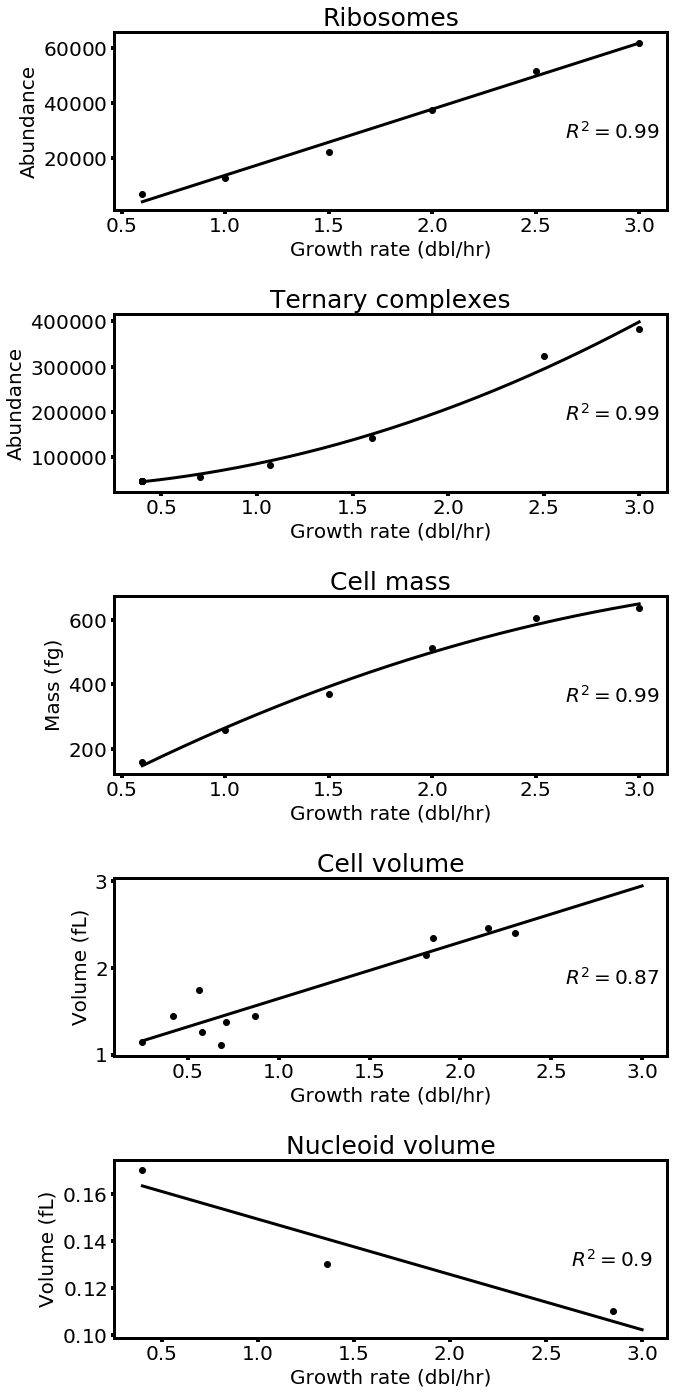

In [68]:
#Calculation of polynomial fits are in analysis_parameters.py
from analysis_parameters import *
from sympy import S, symbols, expand, Symbol
import sympy
import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,2))

def calc_R2(x,y,y_hat):
    SS_tot = np.sum((y-np.average(y))**2) #Sum of squares total (proportional to variance; n times larger than variance)
    SS_err = np.sum((y-y_hat)**2) # Sum of squared errors
    return 1-SS_err/SS_tot

dbl_rate_list = list()
for i in range(len(label_vals)):
    dbl_rate_list.append(np.arange(min(x_vals[i]),3.01,0.01))

ribs = [f_rib(i) for i in dbl_rate_list[0]]
tern = [f_tern(i) for i in dbl_rate_list[1]]
mass = [f_mass(i) for i in dbl_rate_list[2]]
vol = [f_vol(i) for i in dbl_rate_list[3]]
nuc = [f_nuc(i) for i in dbl_rate_list[4]]

fig,ax = plt.subplots(5,1,figsize=(10,20))

y_labels = ['Abundance','Abundance','Mass (fg)','Volume (fL)', 'Volume (fL)']
y_fits = [ribs,tern,mass,vol,nuc]
fits = [lambda x:f_rib(x),lambda x:f_tern(x),lambda x:f_mass(x),lambda x:f_vol(x), lambda x:f_nuc(x)]
R2_arr = list()

for i in range(len(y_vals)):
    R2_arr.append(np.around(calc_R2(x_vals[i],y_vals[i],fits[i](x_vals[i])),2))
    
    ax[i].yaxis.offsetText.set_fontsize(20)
    ax[i].yaxis.set_major_formatter(formatter)
    
    ax[i].plot(dbl_rate_list[i],y_fits[i],color='black',linewidth=3)
    ax[i].scatter(x_vals[i],y_vals[i],color='black')
    
    ax[i].spines['left'].set_linewidth(3)
    ax[i].spines['bottom'].set_linewidth(3)
    ax[i].spines['top'].set_linewidth(3)
    ax[i].spines['right'].set_linewidth(3)
    ax[i].set_ylabel(y_labels[i],size=20)
    ax[i].set_xlabel('Growth rate (dbl/hr)',size=20)
    ax[i].tick_params(axis='both', which='major',width=4, labelsize=20)
    ax[i].set_title(label_vals[i],fontsize=25)
    ax[i].text(0.9,0.4,r'$R^2=$'+str(R2_arr[-1]),horizontalalignment='center',transform=ax[i].transAxes,fontsize=20)

plt.tight_layout(pad=3.0)
print(R2_arr)

### Plot 1) number of crowders per cell vs. growth rate, and 2) abundances of ternary complexes, ribosomes, and crowders in a translation voxel across growth rate. Do so by instantiating cell/voxel parametrization class.

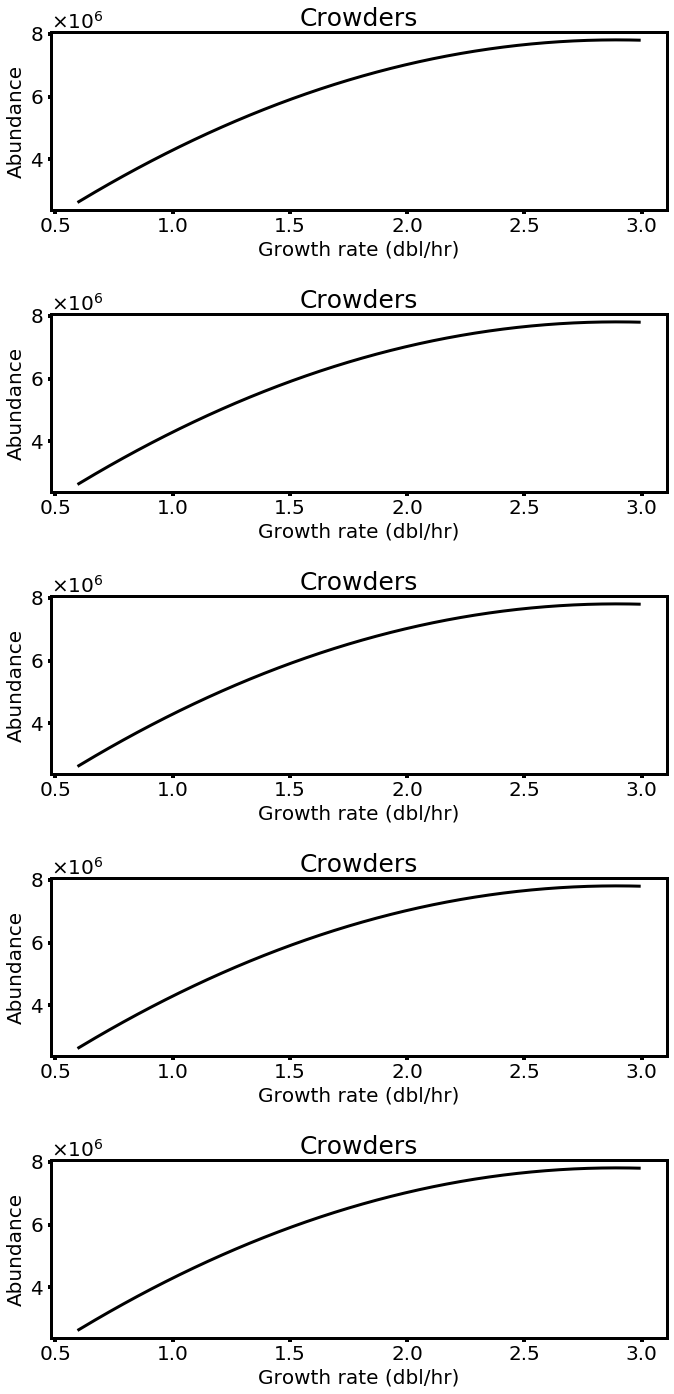

In [69]:
#Also need to fill out references for table based on existing text
import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,2))
dbl_rate=np.arange(0.6,3.0,0.01)
crowderAbundance = list()
for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    crowderAbundance.append(cellParams[2][2])

fig,[ax0,ax1,ax2,ax3,ax4] = plt.subplots(5,1,figsize=(10,20))
for ax in [ax0,ax1,ax2,ax3,ax4]:
    ax.yaxis.offsetText.set_fontsize(20)
    ax.yaxis.set_major_formatter(formatter)
    ax.plot(dbl_rate,crowderAbundance,color='black',linewidth=3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.set_ylabel('Abundance',size=20)
    ax.set_xlabel('Growth rate (dbl/hr)',size=20)
    ax.tick_params(axis='both', which='major',width=4, labelsize=20)
    ax.set_title('Crowders',fontsize=25)
    plt.tight_layout(pad=3.0)

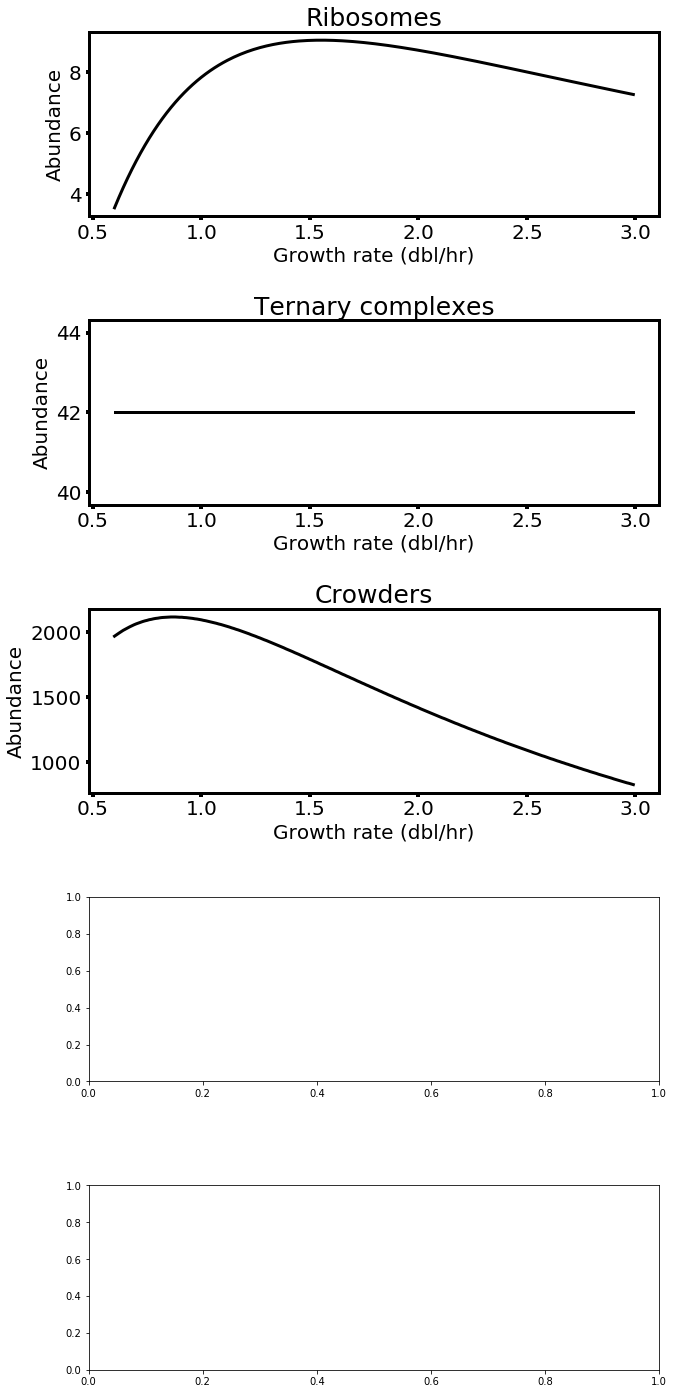

In [39]:
dbl_rate=np.arange(0.6,3.0,0.01)
ribAbundance_vox = list()
ternAbundance_vox = list()
crowderAbundance_vox = list()

for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    ribAbundance_vox.append(voxelParams[2][0])
    ternAbundance_vox.append(voxelParams[2][1])
    crowderAbundance_vox.append(voxelParams[2][2])

fig,ax = plt.subplots(5,1,figsize=(10,20))
abundances = [ribAbundance_vox,ternAbundance_vox, crowderAbundance_vox]
labels = ['Ribosomes','Ternary complexes', 'Crowders']

for i,count in enumerate(abundances):
    ax[i].plot(dbl_rate,count,color='black',linewidth=3)
    ax[i].spines['left'].set_linewidth(3)
    ax[i].spines['bottom'].set_linewidth(3)
    ax[i].spines['top'].set_linewidth(3)
    ax[i].spines['right'].set_linewidth(3)
    ax[i].set_ylabel('Abundance',size=20)
    ax[i].set_xlabel('Growth rate (dbl/hr)',size=20)
    ax[i].tick_params(axis='both', which='major',width=4, labelsize=20)
    ax[i].set_title(labels[i],fontsize=25)
plt.tight_layout(pad=3.0)

### Plot 1) Change in total and relative volume fraction of the voxel with doubling rate, and 2) Change in empirical elongation time with voxel volume fraction

Total voxel volume fraction:  [0.14774807656744338, 0.15034672570490815, 0.15290500549250924, 0.15545694252439418, 0.15796804030148973, 0.1604378375146172, 0.16290095801748106, 0.1653575588250901, 0.1677722615190017, 0.17014455982551896, 0.1725458800825646, 0.1748684390146956, 0.17722028899906223, 0.1795289414130485, 0.18179384109929272, 0.18408862936008005, 0.1863394433472468, 0.18854570168648382, 0.19074461456553363, 0.19293628602936225, 0.19512081838118583, 0.19725979576880653, 0.1993913518993629, 0.2014765798803043, 0.20355408286763588]

Ribosome volume fraction:  [0.04244540647365956, 0.044102736294574396, 0.04574404375241005, 0.04736954616118066, 0.04897945693703641, 0.05057398568524649, 0.052153338284862745, 0.05371771697113679, 0.05526732041575894, 0.05680234380498626, 0.05832297891572412, 0.059829414189623634, 0.06132183480525498, 0.06280042274841453, 0.06426535688062236, 0.0657168130058633, 0.06715496393562499, 0.06857997955228254, 0.06999202687087891, 0.07139127009934858, 0.

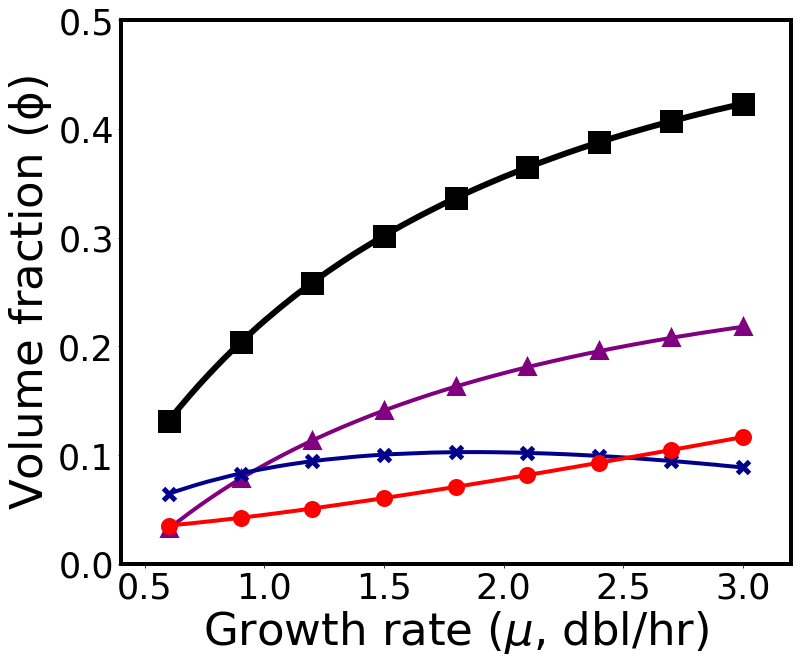

In [7]:
dbl_rate=np.arange(0.6,3.01,0.01)
vox_len = list()
rib_volfrac=list()
tern_volfrac = list()
crowder_volfrac = list()
total_volfrac =list()
for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    vox_len.append(voxelParams[0])
    rib_volfrac.append(voxelParams[1][0])
    tern_volfrac.append(voxelParams[1][1])
    crowder_volfrac.append(voxelParams[1][2])
    total_volfrac.append(voxelParams[1][3])
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig,ax1 = plt.subplots(1,1,figsize=(12,10))

ax1.plot(dbl_rate,total_volfrac,label=r'$\mathregular{\phi_{ voxel}}$',color='black',marker='s',markersize=18,markeredgewidth=5,linewidth=6,markevery=30)
ax1.plot(dbl_rate,rib_volfrac,label=r'$\mathregular{\phi_{ ribosome}}$',color='purple',marker='^',markersize=12,markeredgewidth=5,linewidth=4,markevery=30)
ax1.plot(dbl_rate,crowder_volfrac,label=r'$\mathregular{\phi_{ protein}}$',color='darkblue',marker='x',markersize=12,markeredgewidth=5,linewidth=4,markevery=30)
ax1.plot(dbl_rate,tern_volfrac,label=r'$\mathregular{\phi_{ tRNA}}$',color='red',marker='o',markersize=12,markeredgewidth=5,linewidth=4,markevery=30)
#ax1.legend(loc='upper center', bbox_to_anchor=(1, 1.1),ncol=1,prop={'size':20})
#ax1.legend(prop={'size':25})
ax1.set_xlabel("Growth rate ($\mu$, dbl/hr)",fontsize=45)
ax1.set_ylabel("Volume fraction ($\mathregular{\phi}$)",fontsize=45)
ax1.tick_params(axis='both', which='major', labelsize=35)
ax1.set_xlim(0.40,3.2)

ax1.set_ylim(0,0.5)
ax1.spines['right'].set_linewidth(4)
ax1.spines['left'].set_linewidth(4)
ax1.spines['top'].set_linewidth(4)
ax1.spines['bottom'].set_linewidth(4)


print('Total voxel volume fraction: ', total_volfrac[6:31])
print('\nRibosome volume fraction: ',rib_volfrac[6:31])
print('\nCrowder volume fraction: ',crowder_volfrac[6:31])
print('\nTernary complex volume fraction',tern_volfrac[6:31])

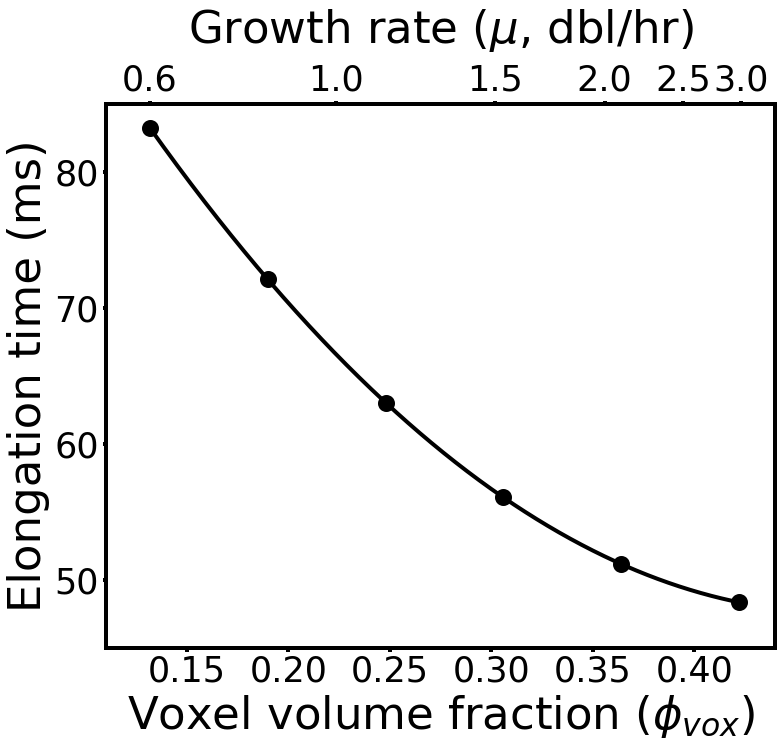

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
phi_list=np.take(total_volfrac,[60-60,100-60,150-60,200-60,250-60,300-60])
y_model,SS_err,_,_,_ = np.polyfit(phi_list,[1000/12,1000/15,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,phi_list)
x_sweep_i = np.linspace(min(phi_list),max(phi_list),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=12,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.tick_params(axis='both', which='major',width=4, labelsize=35)
ax.set_xlim(0.11,0.44)
ax.set_ylim(45,85)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.set_xlabel('Voxel volume fraction ($\phi_{vox})$',size=45,color='black')
ax.set_ylabel('Elongation time (ms)',size=45,color='black')

ax1 = ax.twiny()
ax1.set_xlim(0.11,0.44)
ax1.tick_params(axis='both', which='major',width=4, labelsize=35)
#ax1.scatter(x_sweep_i,y_hat_sweep_i)
ax1.set_xticks(phi_list)
ax1.set_xlabel('Growth rate ($\mu$, dbl/hr)',size=45,color='black',labelpad=20)
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0.6','1.0','1.5','2.0','2.5','3.0']
ax1.set_xticklabels(labels)
ax.set_xticks(np.arange(0.15,0.41,0.05))